# Analysis of  Connectivity Across Experimental Groups for Significant areas

This Jupyter notebook performs various analyses on brain **only connectivity data for only the significant brain areas** from different experimental groups (Control, Familiar, and Unfamiliar). The aim is to explore correlations and connections between different brain regions based on their cell counts and anatomical connections.

## Overview

The notebook is divided into the following sections:
1. **Data Loading and Preprocessing**: It loads necessary libraries, data files (e.g., cell counts and volume information), and performs preliminary data cleaning.
4. **Anatomical connectivity**: The anatomical connectivity data (density and strength) are displayed only for significant areas.
5. **Graph Construction**: Correlation matrices are converted into graphs where nodes represent brain areas, and edges represent anatomical connection densities between the areas. These graphs are constructed and visualized for each experimental group.
6. **Graph Visualization and Degree Analysis**: Indegree and outdegree graphs are generated from the correlation matrices. This helps visualize the strength of connections between different brain regions.

## Key Functions

### `create_corr_matrix()`
This function generates correlation matrices for each experimental group based on cell count data. It loads data, divides the subjects into groups, and calculates Pearson correlation coefficients for each group.

### `plot_three_matrices()`
This function plots three correlation matrices side-by-side for easy visual comparison. It uses seaborn heatmaps to display the data.

### `dot_product_with_nan()`
This utility function calculates the dot product between two matrices, ignoring NaN values, which is useful when multiplying functional and anatomical matrices.

### `multiply_matrices()`
This function multiplies functional connectivity matrices (correlation matrices) with anatomical connectivity matrices (such as density and strength) to study the interaction between functional and structural connectivity.

### `create_graph()` and `create_graph_from_triangle()`
These functions convert correlation matrices into graphs. Each node represents a brain area, and edges represent correlations between areas. The graphs are filtered based on a specified threshold to focus on significant correlations.

## Data Visualization

The notebook includes numerous plots to visualize the results:
- **Correlation heatmaps**: Log-transformed connection densities and strengths are displayed using heatmaps.
- **Functional-anatomical interaction heatmaps**: Combined functional and anatomical matrices are visualized to highlight interactions.
- **Graph-based visualizations**: Graphs of brain region connectivity are generated for each experimental group, highlighting indegree and outdegree connections.

## Final Outputs
The notebook produces detailed visualizations and graphs for brain area connectivity and interaction analysis across the three groups (Control, Familiar, and Unfamiliar) **for both c57 mice with and without father for only significant brain areas and only anatomically**. It also allows for in-depth analysis of correlation-based interactions between brain regions.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import analyze_cells_energy as ace
import utils
from utils_graphs import fig_graph_degrees
import networkx as nx
import igraph as ig
import leidenalg as la

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [61]:
threshold=0.000001

In [4]:
def create_corr_matrix(path, volumes, value='n_cells', group_labels=['Control','Fam', 'Unfam']):
    """
    Create correlation matrices for cell counts across brain areas.

    This function loads cell count data from a specified path, divides the data into experimental groups,
    calculates cell counts across groups, renames brain areas using acronyms, removes null values, and 
    generates Pearson correlation matrices for each experimental group.

    Parameters:
    path (str): Path to the numpy file containing cell count data.
    volumes (pd.DataFrame): DataFrame containing volume information with 'safe_name' and 'acronym' columns.
    value (str): The key in the dictionary to extract the cell counts. Default is 'n_cells'.
    group_labels (list): List of group labels for dividing the subjects. Default is ['Control', 'Fam', 'Unfam'].

    Returns:
    list: A list of correlation matrices for each experimental group.
    """

    # Load the dictionary containing cell count data
    dictionary = np.load(path, allow_pickle=True).item()

    # Divide subjects into experimental groups
    experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dictionary.keys()),
                                                    group_labels=group_labels)

    # Calculate cell counts across experimental groups
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                            dict_results_across_mice=dictionary, 
                                            value=value)

    # Rename brain areas with acronyms
    for df in dfs:
        for i in df.index:
            df.at[i, 'area'] = volumes[volumes['safe_name'] == df.at[i, 'area']]['acronym'].values[0]

    # Remove rows with null values or where all values are zero
    for i, df in enumerate(dfs):
        df = df.set_index('area')
        df = df.loc[~(df == 0).all(axis=1)].dropna(axis=0)
        dfs[i] = df

    # Find intersecting indexes (areas) across all DataFrames
    indexes_intersect = dfs[0].index.intersection(dfs[1].index).intersection(dfs[2].index)

    # Initialize a list to store correlation matrices
    matrices = []

    # Create correlation matrices for each DataFrame
    for df in dfs:
        df = df.loc[indexes_intersect]
        corr_matrix = df.T.corr(method='pearson')
        matrices.append(corr_matrix)

    return matrices

In [5]:
def plot_three_matrices(matrices, corr=True):
    """
    Plot three correlation matrices side by side as heatmaps.

    This function creates a figure with three subplots, each displaying a heatmap of a correlation matrix.
    The heatmaps use a diverging color palette and the color bar is shown only for the last subplot.
    The x and y tick labels are displayed at regular intervals.

    Parameters:
    matrices (list): A list of three correlation matrices (pandas DataFrames).

    Returns:
    tuple: The figure and axes objects for further customization if needed.
    """

    # Create a figure with three subplots side by side
    f, ax = plt.subplots(1, 3, figsize=(12, 2.7))
    plt.subplots_adjust(top=0.97, bottom=0.2)

    # Loop over each matrix to plot
    for i, matrix in enumerate(matrices):
        # Display the color bar only for the last subplot
        cbar = False if i != 2 else True
        # Create the heatmap
        sns.heatmap(matrix,
                    cmap=sns.diverging_palette(220, 10, as_cmap=True),
#                     vmin=-1.0, vmax=1.0,
                    square=True, cbar=cbar, ax=ax[i])
        
        # Remove axis labels
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')

        # Indices of the labels to show (every 12th)
        n = 12
        tick_indices = list(range(0, len(matrix.columns), n))
        tick_labels = matrix.columns[::n]

        # Set x and y ticks
        ax[i].set_xticks(tick_indices)
        ax[i].set_xticklabels(tick_labels)
        ax[i].set_yticks(tick_indices)
        ax[i].set_yticklabels(tick_labels)

    return f, ax

In [6]:
# Function to perform dot product ignoring NaNs
def dot_product_with_nan(A, B):
    A[A < 0] = np.nan
    result = pd.DataFrame(np.nan, index=A.index, columns=B.columns)
    for i in A.index:
        for j in B.columns:
            a_valid = A.loc[i].notna()
            b_valid = B.loc[:, j].notna()
            valid = a_valid & b_valid
            if valid.any():
                result.at[i, j] = np.nansum(A.loc[i, valid] * B.loc[valid, j])
    return result

In [7]:
def multiply_matrices(functional_connectivity, anatomical_connectivity):
    # Step 1: Ensure indices and columns of A are subsets of those in B
    assert set(functional_connectivity.index).issubset(anatomical_connectivity.index)
    assert set(functional_connectivity.columns).issubset(anatomical_connectivity.columns)

    # Step 2: Subset B to match A's rows and columns
    anatomical_connectivity_subset = \
    anatomical_connectivity.loc[functional_connectivity.index, functional_connectivity.columns]

    # Step 3: Multiply the matrices
    result = dot_product_with_nan(A=functional_connectivity,
                                 B=anatomical_connectivity_subset)
    return result

In [8]:
def create_graph(corr_matrix, volumes, threshold, indegree=True):
    """
    This function creates a graph from a correlation matrix. The nodes of the graph are the areas, 
    and the edges are the correlations between the areas. The function also allows you to subsample the areas 
    based on a list of significant areas. The nodes of the graph are labeled with the 
    acronyms of the areas. The weights of the edges are the correlations between the areas. 
    The function returns the graph. 
    
    Args:
        corr_matrix (pd.DataFrame): A correlation matrix.
        volumes (pd.DataFrame): A DataFrame containing area names and their corresponding acronyms.
    Returns:
        G (nx.Graph): A graph where the nodes are the areas and the edges are the correlations.
    """
    # Stack the correlation matrix and reset the index
    df_graph = corr_matrix.stack().reset_index(level=0)
    df_graph.columns = ['area2', 'corr']
    df_graph = df_graph.reset_index()
    df_graph.columns = ['area1', 'area2', 'corr']
    
    # Subsample areas only if the significant areas are given
    significant_areas = corr_matrix.columns.to_list()
  
    # Filter the correlations based on the corr_threshold and correlations parameters
    if indegree:
        links_filtered=df_graph.loc[(df_graph['corr'] > threshold) &
                                (df_graph['area1'] != df_graph['area2'])]
    else:
        links_filtered=df_graph.loc[(df_graph['corr'] > threshold) &
                                (df_graph['area2'] != df_graph['area1'])]
        
    # Create a dictionary of acronyms
    G = nx.Graph()
    dictionary_labels = {area:area\
                     for area in significant_areas}
    
    # Create weights based on correlations
    list_links_filtered = [(dictionary_labels[links_filtered['area1'].loc[i]], 
                        dictionary_labels[links_filtered['area2'].loc[i]], 
                        links_filtered['corr'].loc[i]) for i, row in links_filtered.iterrows()]
    
    
    # Build the graph
    G.add_nodes_from(dictionary_labels)
    
    G = nx.relabel_nodes(G=G, mapping=dictionary_labels, copy=False)
    G.add_weighted_edges_from(list_links_filtered)
    return G

In [9]:
def create_graph_from_triangle(corr_matrix, volumes, threshold, use_upper=True):
    """
    This function creates a graph from a specified triangle (upper or lower) of a correlation matrix. 
    The nodes of the graph are the areas, and the edges are the correlations between the areas. 
    The function also allows you to subsample the areas based on a list of significant areas. 
    The nodes of the graph are labeled with the acronyms of the areas. 
    The weights of the edges are the correlations between the areas. 
    The function returns the graph. 
    
    Args:
        corr_matrix (pd.DataFrame): A correlation matrix.
        volumes (pd.DataFrame): A DataFrame containing area names and their corresponding acronyms.
        threshold (float): The threshold for filtering correlations.
        use_upper (bool): If True, use the upper triangle of the matrix. If False, use the lower triangle.
    Returns:
        G (nx.Graph): A graph where the nodes are the areas and the edges are the correlations.
    """
    # Create mask for upper or lower triangle
    if use_upper:
        mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    else:
        mask = np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)

    # Apply mask to get the specified triangle of the correlation matrix
    corr_matrix_triangle = corr_matrix.where(mask)

    # Stack the specified triangle correlation matrix and reset the index
    df_graph = corr_matrix_triangle.stack().reset_index(level=0)
    df_graph.columns = ['area2', 'corr']
    df_graph = df_graph.reset_index()
    df_graph.columns = ['area1', 'area2', 'corr']
    
    # Subsample areas only if the significant areas are given
    significant_areas = corr_matrix.columns.to_list()
  
    # Filter the correlations based on the corr_threshold and correlations parameters
    links_filtered = df_graph.loc[(df_graph['corr'] > threshold)]
        
    # Create a dictionary of acronyms
    dictionary_labels = {area: area for area in significant_areas}
    
    # Create weights based on correlations
    list_links_filtered = [(dictionary_labels[links_filtered['area1'].iloc[i]], 
                            dictionary_labels[links_filtered['area2'].iloc[i]], 
                            links_filtered['corr'].iloc[i]) for i in range(len(links_filtered))]
    
    # Build the undirected graph
    G = nx.Graph()  # Use Graph for undirected graph
    G.add_nodes_from(dictionary_labels)
    
    G = nx.relabel_nodes(G=G, mapping=dictionary_labels, copy=False)
    G.add_weighted_edges_from(list_links_filtered)
    return G

# Load anatomical data

In [10]:
norm_connection_density = \
pd.read_csv('/home/stella/Documents/Torino/projects/SexualImprinting/Allen_connectivity/normalized_connection_density_ipsi.csv',
               header=0, index_col=0) 

norm_connection_strength = \
pd.read_csv('/home/stella/Documents/Torino/projects/SexualImprinting/Allen_connectivity/normalized_connection_strength_ipsi.csv',
               header=0, index_col=0) 

Text(0.5, 1.0, 'Log-Transformed Connection Strength')

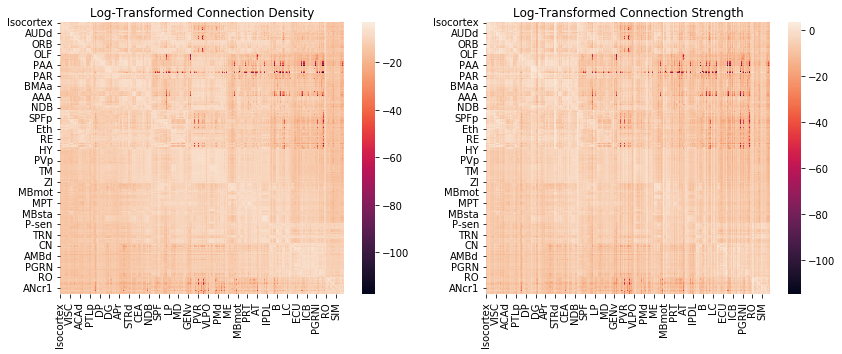

<Figure size 576x432 with 0 Axes>

In [11]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

# Replace zeros with NaN
df_density_replaced = norm_connection_density.replace(0, np.nan)

# Apply the logarithm to the values (using natural logarithm)
log_density_values = np.log(df_density_replaced)

# Plot the heatmap
sns.heatmap(log_density_values, annot=False, cbar=True, ax=axes[0])

axes[0].set_title('Log-Transformed Connection Density')

# Replace zeros with NaN
df_strength_replaced = norm_connection_strength.replace(0, np.nan)

# Apply the logarithm to the values (using natural logarithm)
log_strength_values = np.log(df_strength_replaced)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_strength_values, annot=False, cbar=True, ax=axes[1])

axes[1].set_title('Log-Transformed Connection Strength')


# Load results functional data

In [12]:
matrices_c57_with_father = create_corr_matrix(
    path='dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy',
                              volumes=volumes)

In [13]:
dict_c57_with_father = np.load('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy',
                              allow_pickle=True).item()
groups_c57_with_father =  utils.divide_in_exp_groups(list_subjects=list(dict_c57_with_father.keys()))

In [14]:
groups_control_fam = {key: groups_c57_with_father[key] for key in ['Control', 'Fam']}
groups_control_unfam = {key: groups_c57_with_father[key] for key in ['Control', 'Unfam']}

subjects_control_fam = [item for sublist in groups_control_fam.values() for item in sublist]
subjects_control_unfam = [item for sublist in groups_control_unfam.values() for item in sublist]

In [15]:
dict_control_fam = {subj:dict_c57_with_father[subj] for subj in subjects_control_fam}
dict_control_unfam = {subj:dict_c57_with_father[subj] for subj in subjects_control_unfam}

In [23]:
significant_areas_c57_with_father_ctrl_vs_fam = ace.select_significant_areas(dictionary=dict_control_fam, 
                                             experimental_groups=groups_control_fam, 
                                             batch='c57',
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='n_cells', 
                                             value_pls='relative_density',
                                             pls=False)

significant_areas_c57_with_father_ctrl_vs_fam = [volumes[volumes['safe_name']==area]['acronym'].values[0] \
                                     for area in significant_areas_c57_with_father_ctrl_vs_fam]

significant_areas_c57_with_father_ctrl_vs_unfam = ace.select_significant_areas(dictionary=dict_control_unfam, 
                                             experimental_groups=groups_control_unfam, 
                                             batch='c57',
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='n_cells', 
                                             value_pls='relative_density',
                                             pls=False)

significant_areas_c57_with_father_ctrl_vs_unfam = [volumes[volumes['safe_name']==area]['acronym'].values[0] \
                                     for area in significant_areas_c57_with_father_ctrl_vs_unfam]

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# Filter only for significant areas

In [24]:
matrix_c57_with_father_ctrl_vs_fam = norm_connection_density.loc[
    list(significant_areas_c57_with_father_ctrl_vs_fam),
    list(significant_areas_c57_with_father_ctrl_vs_fam)]

matrix_c57_with_father_ctrl_vs_unfam = norm_connection_density.loc[
    list(significant_areas_c57_with_father_ctrl_vs_unfam),
    list(significant_areas_c57_with_father_ctrl_vs_unfam)]

# Plot matrices and distributions (in and outdegrees)

Text(0.5, 1.0, 'Control vs Unfam')

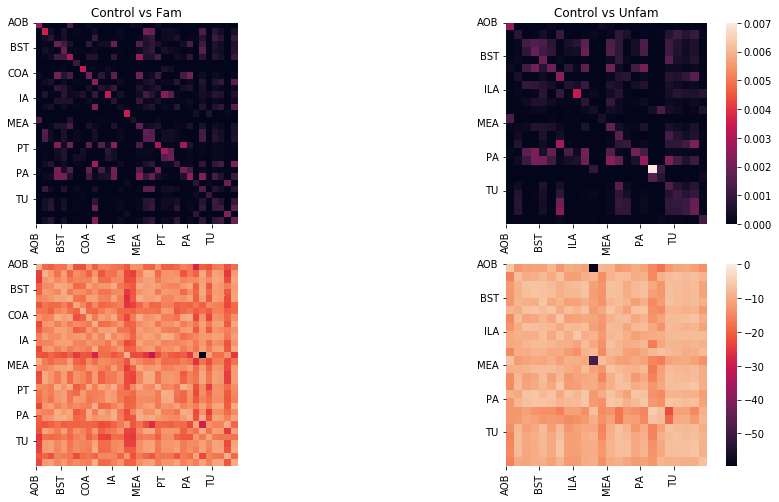

In [52]:
vmax = np.max([np.max(np.max(matrix_c57_with_father_ctrl_vs_fam)),
       np.max(np.max(matrix_c57_with_father_ctrl_vs_unfam))])

# Create a figure with three subplots side by side
f, ax = plt.subplots(2, 2, figsize=(15, 8))
plt.subplots_adjust(top=0.97, bottom=0.2)

for j in [0,1]:
    # Loop over each matrix to plot
    for i, matrix in enumerate([matrix_c57_with_father_ctrl_vs_fam,
                               matrix_c57_with_father_ctrl_vs_unfam]):
        # Display the color bar only for the last subplot
        cbar = False if i != 1 else True
        # Create the heatmap:
        if j==0:
            sns.heatmap(matrix,
                        square=True, cbar=cbar, ax=ax[j][i],
                        vmax=vmax)
        else:
            sns.heatmap(np.log(matrix),
                        square=True, cbar=cbar, ax=ax[j][i],
                        vmax=vmax)

        # Remove axis labels
        ax[j][i].set_ylabel('')
        ax[j][i].set_xlabel('')

        # Indices of the labels to show (every 12th)
        n = 4
        tick_indices = list(range(0, len(matrix.columns), n))
        tick_labels = matrix.columns[::n]

        # Set x and y ticks
        ax[j][i].set_xticks(tick_indices)
        ax[j][i].set_xticklabels(tick_labels)
        ax[j][i].set_yticks(tick_indices)
        ax[j][i].set_yticklabels(tick_labels)
ax[0][0].set_title('Control vs Fam')
ax[0][1].set_title('Control vs Unfam')

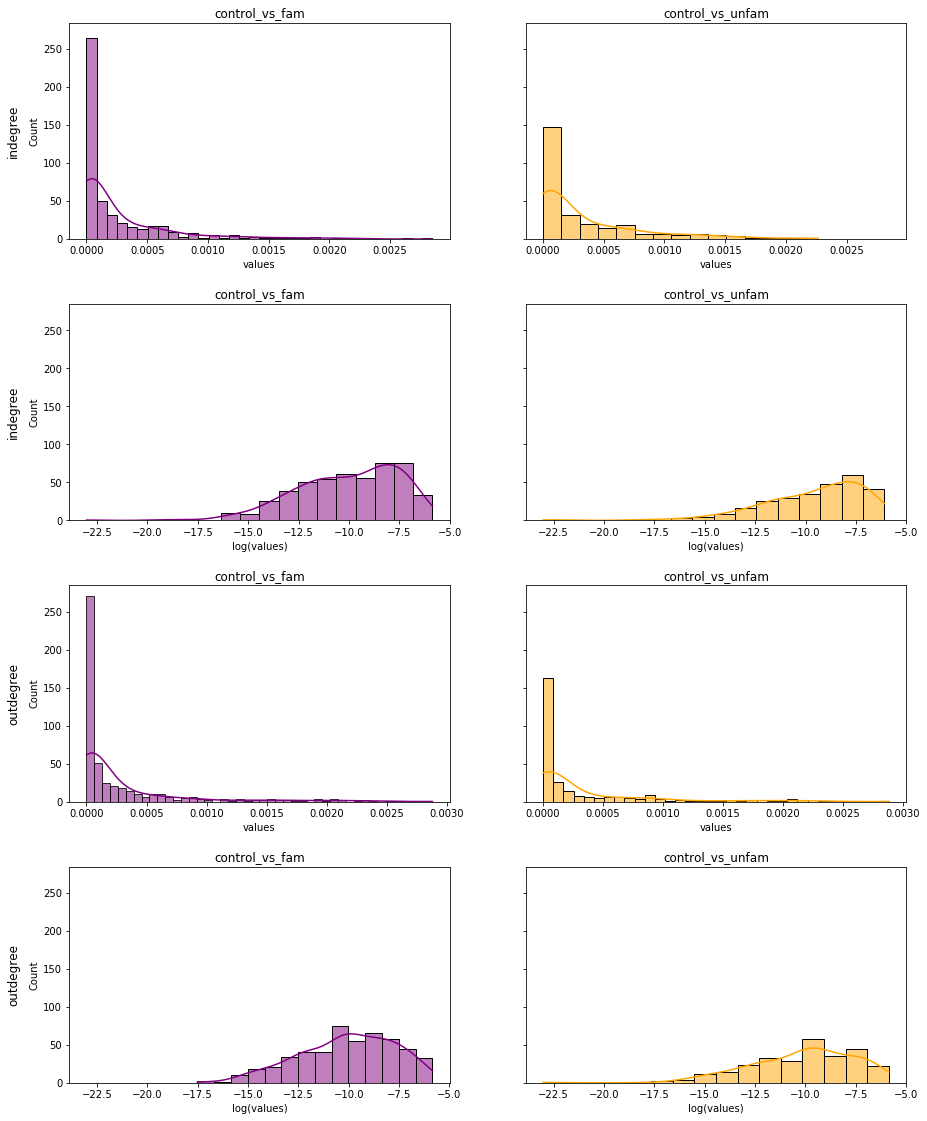

In [55]:
# Create a figure with four rows and three columns
f, ax = plt.subplots(4, 2, figsize=(15, 16), sharey=True, sharex='row')
plt.subplots_adjust(top=0.97, bottom=0.05, hspace=0.3)

# Colors and labels
colors = ['purple', 'orange']
labels = ['control_vs_fam', 'control_vs_unfam']

# Titles for rows
row_titles = ['indegree', 'indegree', 'outdegree', 'outdegree']

# Loop to create plots
for j in range(4):
    for i, (matrix, color, label) in enumerate(zip([matrix_c57_with_father_ctrl_vs_fam,
                               matrix_c57_with_father_ctrl_vs_unfam], colors, labels)):
        # Determine whether to plot upper or lower triangle
        if j < 2:  # Upper triangle for the first two rows
            tri_indices = np.triu_indices_from(matrix, k=1)
        else:  # Lower triangle for the last two rows
            tri_indices = np.tril_indices_from(matrix, k=-1)

        # Extract the values from the upper or lower triangle
        values = matrix.values[tri_indices]

        if j % 2 == 1:  # Log scale for odd rows
            values = np.log(values + 1e-10)  # Add a small constant to avoid log(0)

        # Remove zero or nan values from the array
        values = values[values != 0]

        # Create a histogram using seaborn
        sns.histplot(values, kde=True, ax=ax[j][i], color=color, label=label)
        
        if j % 2 == 0:
            ax[j][i].set_xlabel('values')
        else:
            ax[j][i].set_xlabel('log(values)')
        
        # Add legend to each subplot
        ax[j][i].set_title(label)
        
    # Add title to the row
    ax[j][0].annotate(row_titles[j], xy=(0, 0.5), xytext=(-ax[j][0].yaxis.labelpad - 5, 0),
                      xycoords=ax[j][0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)


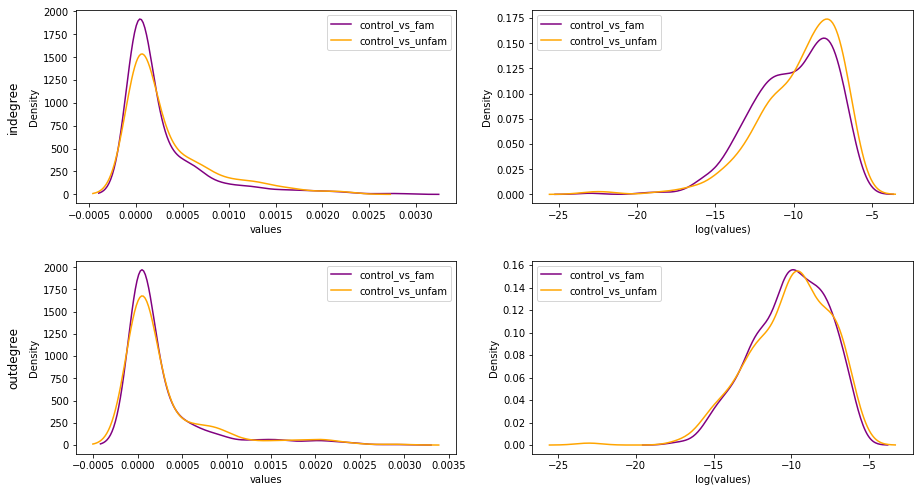

In [57]:
# Create a figure with two rows and two columns
f, ax = plt.subplots(2, 2, figsize=(15, 8))
plt.subplots_adjust(top=0.97, bottom=0.2, hspace=0.3)

# Colors and labels
colors = ['purple', 'orange']
labels = ['control_vs_fam', 'control_vs_unfam']

# Titles for rows
row_titles = ['indegree', 'outdegree']

# Loop to create plots
for j in range(2):
    for i, (matrix, color, label) in enumerate(zip([matrix_c57_with_father_ctrl_vs_fam,
                               matrix_c57_with_father_ctrl_vs_unfam], colors, labels)):
        # Determine whether to plot upper or lower triangle
        if j == 0:  # Upper triangle for the first row
            tri_indices = np.triu_indices_from(matrix, k=1)
        else:  # Lower triangle for the second row
            tri_indices = np.tril_indices_from(matrix, k=-1)

        # Extract the values from the upper or lower triangle
        values = matrix.values[tri_indices]

        # Create a KDE plot using seaborn without histogram bars
        sns.kdeplot(values.flatten(), ax=ax[j][0], color=color, label=label)
        sns.kdeplot(np.log(values.flatten() + 1e-10), ax=ax[j][1], color=color, label=label)

    # Add legend to each subplot
    ax[j][0].legend()
    ax[j][1].legend()

    # Add labels to x-axis
    ax[j][0].set_xlabel('values')
    ax[j][1].set_xlabel('log(values)')

    # Add title to the row
    ax[j][0].annotate(row_titles[j], xy=(0, 0.5), xytext=(-ax[j][0].yaxis.labelpad - 5, 0),
                      xycoords=ax[j][0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)


# Create graphs

# Control vs Familiar

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f632a7e0198>)

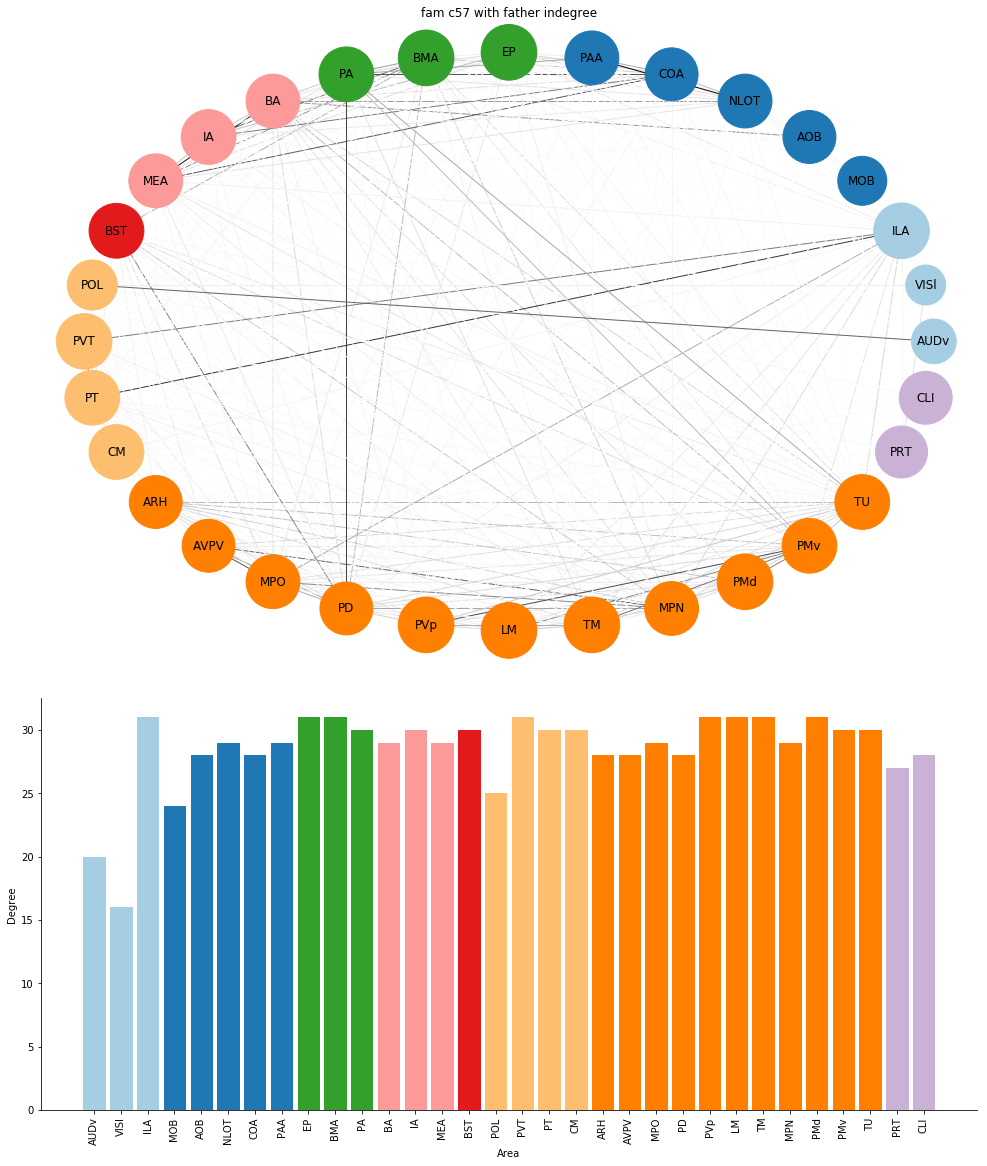

In [62]:
G_fam_c57_wf_indegree = create_graph_from_triangle(corr_matrix=matrix_c57_with_father_ctrl_vs_fam, 
                                                   volumes=volumes, 
                                                   threshold=threshold, 
                                                   use_upper=True)
fig_graph_degrees(G=G_fam_c57_wf_indegree, 
                  title='fam c57 with father indegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f632ad01e48>)

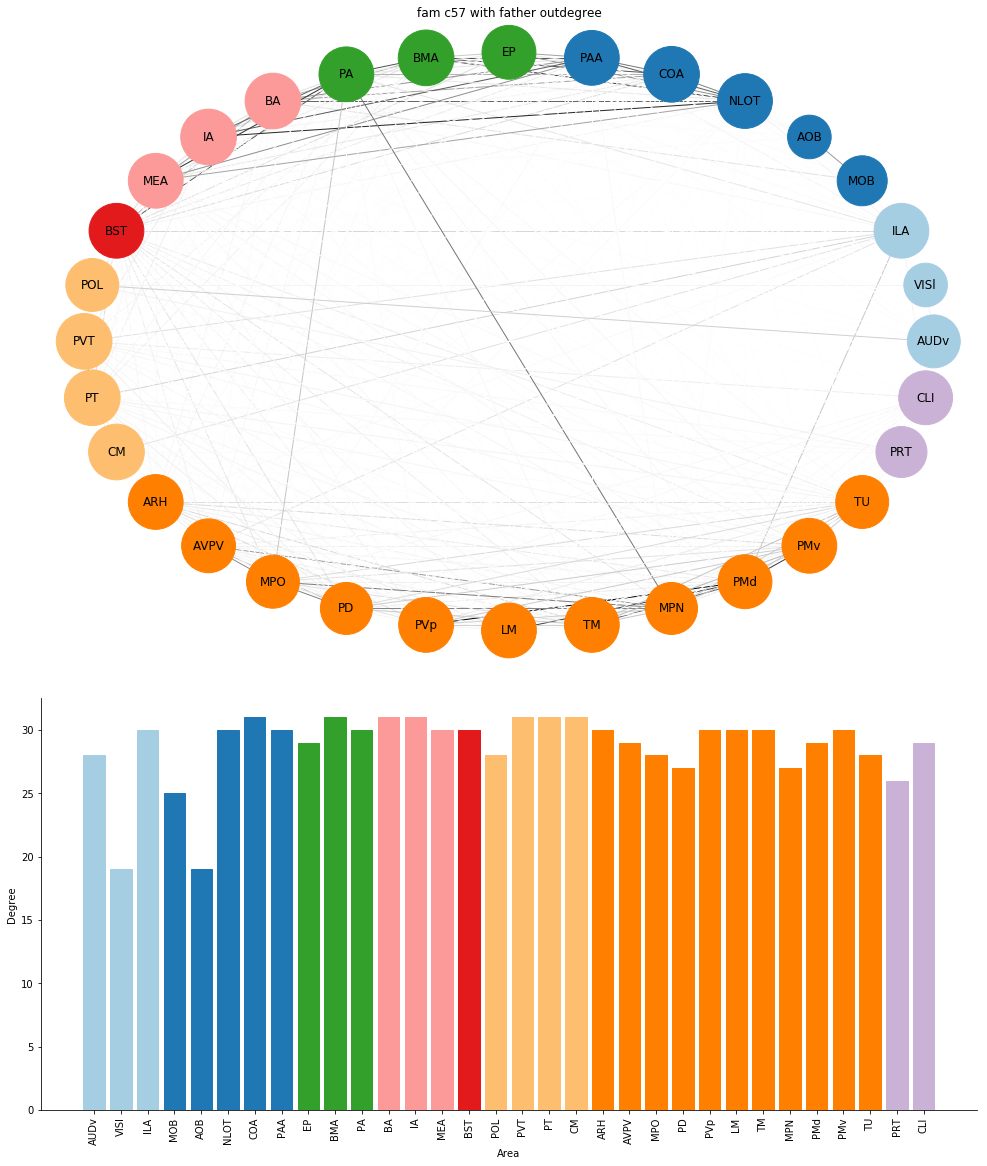

In [63]:
G_fam_c57_wf_outdegree = create_graph_from_triangle(corr_matrix=matrix_c57_with_father_ctrl_vs_fam, 
                                                    volumes=volumes, 
                                                    threshold=threshold, 
                                                    use_upper=False)
fig_graph_degrees(G=G_fam_c57_wf_outdegree, 
                  title='fam c57 with father outdegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

## Unfamiliar

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f632bad2e80>)

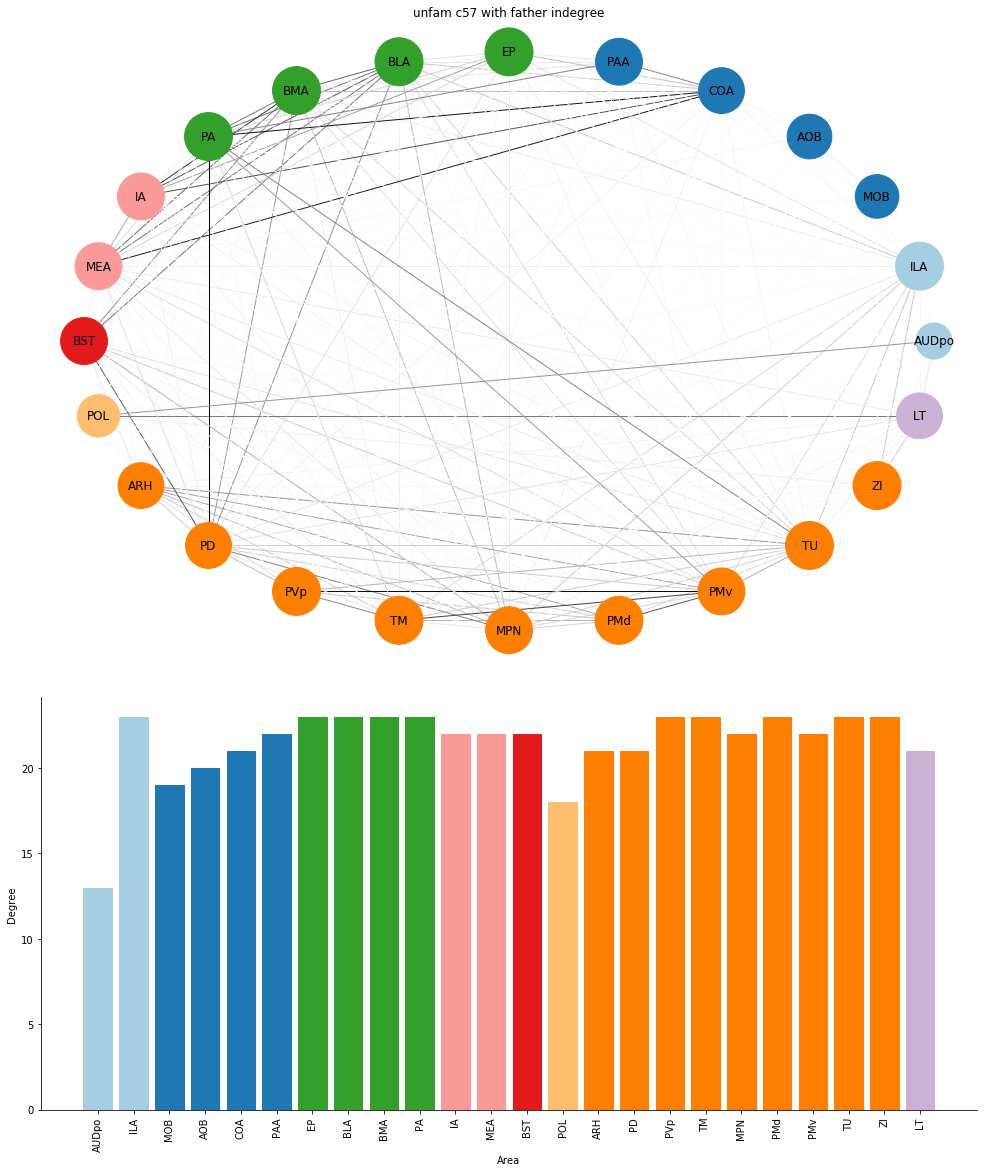

In [64]:
G_unfam_c57_wf_indegree = create_graph_from_triangle(corr_matrix=matrix_c57_with_father_ctrl_vs_unfam, 
                                                     volumes=volumes, 
                                                     threshold=threshold, 
                                                     use_upper=True)
fig_graph_degrees(G=G_unfam_c57_wf_indegree, 
                  title='unfam c57 with father indegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f632ae920f0>)

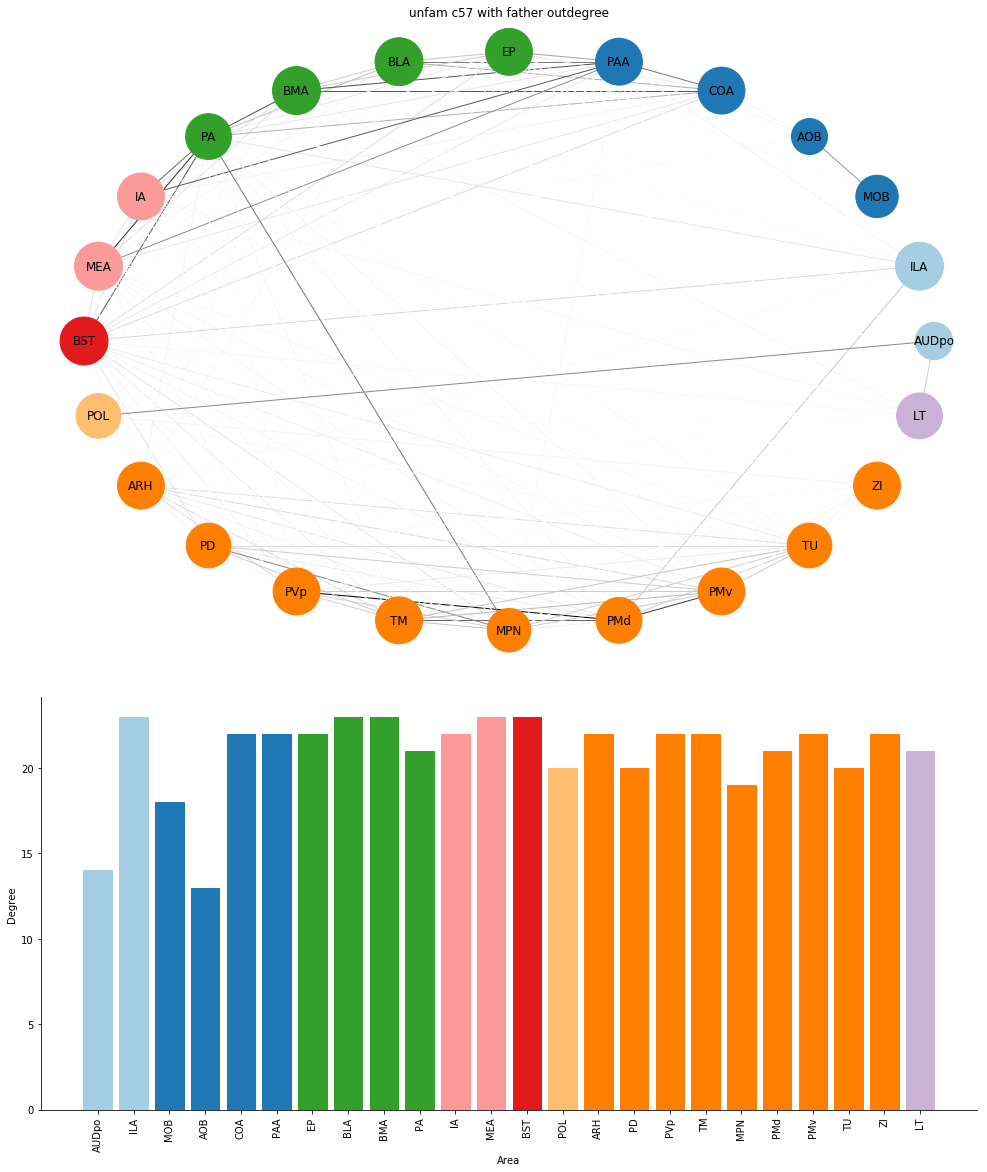

In [65]:
G_unfam_c57_wf_outdegree = create_graph_from_triangle(corr_matrix=matrix_c57_with_father_ctrl_vs_unfam, 
                                                      volumes=volumes, 
                                                      threshold=threshold, 
                                                      use_upper=False)
fig_graph_degrees(G=G_unfam_c57_wf_outdegree, 
                  title='unfam c57 with father outdegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

# Analysis c57 without father

In [ ]:
matrices_c57_without_father = create_corr_matrix(
    path='dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy',
                              volumes=volumes)

In [ ]:
dict_c57_without_father = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy',
                              allow_pickle=True).item()
groups_c57_without_father =  utils.divide_in_exp_groups(list_subjects=list(dict_c57_without_father.keys()))
significant_areas_c57_without_father = ace.select_significant_areas(dictionary=dict_c57_without_father, 
                                             experimental_groups=groups_c57_without_father, 
                                             batch='BL_woF2000',
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='n_cells', 
                                             value_pls='relative_density')
significant_areas_c57_without_father = [volumes[volumes['safe_name']==area]['acronym'].values[0] \
                                     for area in significant_areas_c57_without_father]

In [ ]:
areas_c57_without_father = set(significant_areas_c57_without_father).intersection(
    set(matrices_c57_without_father[0].columns))
matrices_c57_without_father = [matrix.loc[list(areas_c57_without_father), 
                                list(areas_c57_without_father)] for matrix in matrices_c57_without_father]

In [ ]:
f, ax = plot_three_matrices(matrices=matrices_c57_without_father)

In [ ]:
control_c57_wof_merge = multiply_matrices(functional_connectivity=matrices_c57_without_father[0],
                          anatomical_connectivity=norm_connection_density)

In [ ]:
fam_c57_wof_merge = multiply_matrices(functional_connectivity=matrices_c57_without_father[1],
                          anatomical_connectivity=norm_connection_density)

In [ ]:
unfam_c57_wof_merge = multiply_matrices(functional_connectivity=matrices_c57_without_father[2],
                          anatomical_connectivity=norm_connection_density)

In [ ]:
# Create a figure with three subplots side by side
f, ax = plt.subplots(2, 3, figsize=(15, 8))
plt.subplots_adjust(top=0.97, bottom=0.2)

for j in [0,1]:
    # Loop over each matrix to plot
    for i, matrix in enumerate([control_c57_wof_merge,
                               fam_c57_wof_merge, 
                                unfam_c57_wof_merge]):
        # Display the color bar only for the last subplot
        cbar = False if i != 2 else True
        # Create the heatmap:
        if j==0:
            sns.heatmap(matrix,
                        square=True, cbar=cbar, ax=ax[j][i])
        else:
            sns.heatmap(np.log(matrix),
                        square=True, cbar=cbar, ax=ax[j][i])

        # Remove axis labels
        ax[j][i].set_ylabel('')
        ax[j][i].set_xlabel('')

        # Indices of the labels to show (every 12th)
        n = 12
        tick_indices = list(range(0, len(matrix.columns), n))
        tick_labels = matrix.columns[::n]

        # Set x and y ticks
        ax[j][i].set_xticks(tick_indices)
        ax[j][i].set_xticklabels(tick_labels)
        ax[j][i].set_yticks(tick_indices)
        ax[j][i].set_yticklabels(tick_labels)

In [ ]:
# Create a figure with four rows and three columns
f, ax = plt.subplots(4, 3, figsize=(15, 16), sharey=True, sharex='row')
plt.subplots_adjust(top=0.97, bottom=0.05, hspace=0.3)

# Colors and labels
colors = ['green', 'purple', 'orange']
labels = ['control', 'fam', 'unfam']

# Titles for rows
row_titles = ['indegree', 'indegree', 'outdegree', 'outdegree']

# Loop to create plots
for j in range(4):
    for i, (matrix, color, label) in enumerate(zip([control_c57_wof_merge,
                               fam_c57_wof_merge, 
                                unfam_c57_wof_merge], colors, labels)):
        # Determine whether to plot upper or lower triangle
        if j < 2:  # Upper triangle for the first two rows
            tri_indices = np.triu_indices_from(matrix, k=1)
        else:  # Lower triangle for the last two rows
            tri_indices = np.tril_indices_from(matrix, k=-1)

        # Extract the values from the upper or lower triangle
        values = matrix.values[tri_indices]

        if j % 2 == 1:  # Log scale for odd rows
            values = np.log(values + 1e-10)  # Add a small constant to avoid log(0)

        # Remove zero or nan values from the array
        values = values[values != 0]

        # Create a histogram using seaborn
        sns.histplot(values, kde=True, ax=ax[j][i], color=color, label=label)
        
        if j % 2 == 0:
            ax[j][i].set_xlabel('values')
        else:
            ax[j][i].set_xlabel('log(values)')
        
        # Add legend to each subplot
        ax[j][i].set_title(label)
        
    # Add title to the row
    ax[j][0].annotate(row_titles[j], xy=(0, 0.5), xytext=(-ax[j][0].yaxis.labelpad - 5, 0),
                      xycoords=ax[j][0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)


In [ ]:
# Create a figure with two rows and two columns
f, ax = plt.subplots(2, 2, figsize=(15, 8))
plt.subplots_adjust(top=0.97, bottom=0.2, hspace=0.3)

# Colors and labels
colors = ['green', 'purple', 'orange']
labels = ['control', 'fam', 'unfam']

# Titles for rows
row_titles = ['indegree', 'outdegree']

# Loop to create plots
for j in range(2):
    for i, (matrix, color, label) in enumerate(zip([control_c57_wof_merge,
                               fam_c57_wof_merge, 
                                unfam_c57_wof_merge], colors, labels)):
        # Determine whether to plot upper or lower triangle
        if j == 0:  # Upper triangle for the first row
            tri_indices = np.triu_indices_from(matrix, k=1)
        else:  # Lower triangle for the second row
            tri_indices = np.tril_indices_from(matrix, k=-1)

        # Extract the values from the upper or lower triangle
        values = matrix.values[tri_indices]

        # Create a KDE plot using seaborn without histogram bars
        sns.kdeplot(values.flatten(), ax=ax[j][0], color=color, label=label)
        sns.kdeplot(np.log(values.flatten() + 1e-10), ax=ax[j][1], color=color, label=label)

    # Add legend to each subplot
    ax[j][0].legend()
    ax[j][1].legend()

    # Add labels to x-axis
    ax[j][0].set_xlabel('values')
    ax[j][1].set_xlabel('log(values)')

    # Add title to the row
    ax[j][0].annotate(row_titles[j], xy=(0, 0.5), xytext=(-ax[j][0].yaxis.labelpad - 5, 0),
                      xycoords=ax[j][0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)


## Familiar

In [ ]:
G_fam_c57_wof_indegree = create_graph_from_triangle(corr_matrix=fam_c57_wof_merge, 
                                                    volumes=volumes, 
                                                    threshold=threshold, 
                                                    use_upper=True)
fig_graph_degrees(G=G_fam_c57_wof_indegree, 
                  title='fam c57 without father indegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

In [ ]:
G_fam_c57_wof_outdegree = create_graph_from_triangle(corr_matrix=fam_c57_wof_merge, 
                                                      volumes=volumes, 
                                                      threshold=threshold, 
                                                      use_upper=False)
fig_graph_degrees(G=G_fam_c57_wof_outdegree, 
                  title='fam c57 without father outdegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

## Unfamiliar

In [ ]:
G_unfam_c57_wof_indegree = create_graph_from_triangle(corr_matrix=unfam_c57_wof_merge, 
                                                      volumes=volumes, 
                                                      threshold=threshold, 
                                                      use_upper=True)
fig_graph_degrees(G=G_unfam_c57_wof_indegree, 
                  title='unfam c57 without father indegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

In [ ]:
G_unfam_c57_wof_outdegree = create_graph_from_triangle(corr_matrix=unfam_c57_wof_merge, 
                                                       volumes=volumes, 
                                                       threshold=threshold, 
                                                       use_upper=False)
fig_graph_degrees(G=G_unfam_c57_wof_outdegree, 
                  title='unfam c57 without father outdegree', 
                  volumes=volumes, 
                  figsize=(20,20), 
                  show_colorbar=False,
                  show_degrees=True, 
                  show_legend=False)

# Analysis community

## First create directed graphs with igraph starting from indegree and outdegree graph

In [ ]:
def create_directed_igraph_from_networkx(indegree_graph, outdegree_graph):
    """
    This function creates a directed igraph graph from two undirected NetworkX graphs,
    one representing the indegrees and one representing the outdegrees.
    
    Args:
        indegree_graph (nx.Graph): A NetworkX graph where edges represent indegrees.
        outdegree_graph (nx.Graph): A NetworkX graph where edges represent outdegrees.
    
    Returns:
        G_ig (ig.Graph): A directed igraph graph.
    """
    # Combine edges from both graphs
    combined_edges = set(indegree_graph.edges()) | set(outdegree_graph.edges())
    
    # Create a directed igraph graph
    G_ig = ig.Graph(directed=True)
    
    # Add nodes
    nodes = set(indegree_graph.nodes()).union(set(outdegree_graph.nodes()))
    G_ig.add_vertices(list(nodes))
    
    # Add edges with direction
    for u, v in combined_edges:
        if indegree_graph.has_edge(u, v) and not outdegree_graph.has_edge(v, u):
            # Only in indegree graph, add edge (v -> u)
            G_ig.add_edge(v, u)
        elif outdegree_graph.has_edge(u, v) and not indegree_graph.has_edge(v, u):
            # Only in outdegree graph, add edge (u -> v)
            G_ig.add_edge(u, v)
        else:
            # If edge is in both, add both directions
            G_ig.add_edge(u, v)
            G_ig.add_edge(v, u)
    
    return G_ig

### Plotting the directed graphs

In [ ]:
G = create_directed_igraph_from_networkx(indegree_graph=G_ctrl_c57_wf_indegree, 
                                     outdegree_graph=G_ctrl_c57_wf_outdegree)
ig.plot(G, layout='kk',
    vertex_label=G.vs["name"],vertex_label_size=6)

In [ ]:
G = create_directed_igraph_from_networkx(indegree_graph=G_fam_c57_wf_indegree, 
                                     outdegree_graph=G_fam_c57_wf_outdegree)
ig.plot(G, layout='kk',
    vertex_label=G.vs["name"],vertex_label_size=6)

In [ ]:
G = create_directed_igraph_from_networkx(indegree_graph=G_unfam_c57_wf_indegree, 
                                     outdegree_graph=G_unfam_c57_wf_outdegree)
ig.plot(G, layout='kk',
    vertex_label=G.vs["name"],vertex_label_size=6)

In [ ]:
G = create_directed_igraph_from_networkx(indegree_graph=G_ctrl_c57_wof_indegree, 
                                     outdegree_graph=G_ctrl_c57_wof_outdegree)
ig.plot(G, layout='kk',
    vertex_label=G.vs["name"],vertex_label_size=6)

In [ ]:
G = create_directed_igraph_from_networkx(indegree_graph=G_fam_c57_wof_indegree, 
                                     outdegree_graph=G_fam_c57_wof_outdegree)
ig.plot(G, layout='kk',
    vertex_label=G.vs["name"],vertex_label_size=6)

In [ ]:
G = create_directed_igraph_from_networkx(indegree_graph=G_unfam_c57_wof_indegree, 
                                     outdegree_graph=G_unfam_c57_wof_outdegree)
ig.plot(G, layout='kk',
    vertex_label=G.vs["name"],vertex_label_size=6)

## Detect communities

In [ ]:
lapartition = la.find_partition(G, la.CPMVertexPartition,
                                   resolution_parameter = 0.1, n_iterations=10)

In [ ]:
ig.plot(lapartition, layout='kk',
    vertex_label=G.vs["name"],vertex_label_size=6)